In [1]:
import os
import glob
import numpy as np
from scipy import ndimage
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
from nnmnkwii.preprocessing.f0 import interp1d
from nnmnkwii.util import apply_delta_windows
import pandas as pd

import pyworld
import pysptk
import nnmnkwii
import matplotlib.pyplot as plt

In [2]:
def collect_features(wav_path, fs, frame_period, order):
  
    x, sr = librosa.load(wav_path, sr = fs)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)

    mgc = pysptk.sp2mc(spectrogram, order=order,
                       alpha=pysptk.util.mcepalpha(fs))


    mgc_delta = apply_delta_windows(mgc, windows)
    
    return mgc, mgc_delta


def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label = 'Valid Loss')
    plt.legend()

In [3]:
data_folder = '/home/beiming/Desktop/Parsed_data'
group_name = 'SDTL' # ENF or ENM or SDTL
group_folder = os.path.join(data_folder, group_name)
subject_list = os.listdir(group_folder) 
print(subject_list)

['DN004', 'DN011', 'DN006', 'DN008', 'DN009', 'DN005', 'DN007', 'DN010']


In [9]:
mgc_dim = 40
lf0_dim = 1
vuv_dim = 1
bap_dim = 1

fs = 16000

frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

order = 39
frame_period = 5
windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]


train_index = [i for j in (range(0, 122), range(132, 254)) for i in j]
valid_index = [i for j in (range(122, 127), range(254, 259)) for i in j]
test_index = [i for j in (range(127, 132), range(259, 264)) for i in j]

In [310]:
F_Target_Sub = 'DN008'
F_Train_Sub = ['DN010', 'DN006', 'DN007']

M_Target_Sub = 'DN011'
M_Train_Sub = ['DN007','DN005', 'DN010']

In [11]:
Testing_Gender = 'F'

In [7]:
if Testing_Gender == 'F':
    Target_Sub = F_Target_Sub
    Train_Sub = F_Train_Sub
else:
    Target_Sub = M_Target_Sub
    Train_Sub = M_Train_Sub    

In [311]:
data_sub_folder = os.path.join(group_folder, Target_Sub)

Target_WAV_path_list = os.path.join(data_sub_folder, '*' + '.wav')
Target_WAV_path_list = glob.glob(Target_WAV_path_list)
Target_WAV_path_list.sort()

Target_EMA_path_list = os.path.join(data_sub_folder, '*' + '.MV8')
Target_EMA_path_list = glob.glob(Target_EMA_path_list)
Target_EMA_path_list.sort()

In [312]:
Train_sub1_folder = os.path.join(group_folder, Train_Sub[0])
Train1_WAV_path_list = os.path.join(Train_sub1_folder, '*' + '.wav')
Train1_WAV_path_list = glob.glob(Train1_WAV_path_list)
Train1_WAV_path_list.sort()
Train1_EMA_path_list = os.path.join(Train_sub1_folder, '*' + '.MV8')
Train1_EMA_path_list = glob.glob(Train1_EMA_path_list)
Train1_EMA_path_list.sort()

Train_sub2_folder = os.path.join(group_folder, Train_Sub[1])
Train2_WAV_path_list = os.path.join(Train_sub2_folder, '*' + '.wav')
Train2_WAV_path_list = glob.glob(Train2_WAV_path_list)
Train2_WAV_path_list.sort()
Train2_EMA_path_list = os.path.join(Train_sub2_folder, '*' + '.MV8')
Train2_EMA_path_list = glob.glob(Train2_EMA_path_list)
Train2_EMA_path_list.sort()

Train_sub3_folder = os.path.join(group_folder, Train_Sub[2])
Train3_WAV_path_list = os.path.join(Train_sub3_folder, '*' + '.wav')
Train3_WAV_path_list = glob.glob(Train3_WAV_path_list)
Train3_WAV_path_list.sort()
Train3_EMA_path_list = os.path.join(Train_sub3_folder, '*' + '.MV8')
Train3_EMA_path_list = glob.glob(Train3_EMA_path_list)
Train3_EMA_path_list.sort()

In [313]:
Valid_MV = {}
Valid_WAV = {}

index = 0

for i in valid_index:
  
  MV = np.genfromtxt(Target_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Target_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Valid_MV[index] = MV_delta
  Valid_WAV[index] = WAV_delta
  
  index = index + 1 

/home/beiming/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [314]:
Test_MV = {}
Test_WAV = {}

index = 0

for i in test_index:
  
  MV = np.genfromtxt(Target_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Target_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Test_MV[index] = MV_delta
  Test_WAV[index] = WAV_delta
  
  index = index + 1 

In [315]:
Train_MV_1 = {}
Train_WAV_1 = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(Train1_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Train1_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV_1[index] = MV_delta
  Train_WAV_1[index] = WAV_delta
  
  index = index + 1 

In [316]:
Train_MV_2 = {}
Train_WAV_2 = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(Train2_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Train2_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV_2[index] = MV_delta
  Train_WAV_2[index] = WAV_delta
  
  index = index + 1 

In [317]:
Train_MV_3 = {}
Train_WAV_3 = {}

index = 0

for i in train_index:
  
  MV = np.genfromtxt(Train3_EMA_path_list[i], skip_header=1, skip_footer=1)
  
  WAV, WAV_delta = collect_features(Train3_WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV_3[index] = MV_delta
  Train_WAV_3[index] = WAV_delta
  
  index = index + 1 

In [318]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [334]:
def node_split(alpha_init, reduction):
    
    a_1 = [alpha_init[0]*reduction, alpha_init[1], alpha_init[2]]
    a_2 = [alpha_init[0], alpha_init[1]*reduction, alpha_init[2]]
    a_3 = [alpha_init[0], alpha_init[1], alpha_init[2]*reduction]
    
    alpha_1 = a_1/sum(a_1)
    alpha_2 = a_2/sum(a_2)
    alpha_3 = a_3/sum(a_3)
    
    node_1 = np.floor(244 * alpha_1).astype(int)
    node_2 = np.floor(244 * alpha_2).astype(int)
    node_3 = np.floor(244 * alpha_3).astype(int)

    nodes = np.zeros([3,3], int)
    alphas = np.zeros([3,3], float)

    nodes[0,:] = node_1
    nodes[1,:] = node_2
    nodes[2,:] = node_3
    
    alphas[0,:] = alpha_1
    alphas[1,:] = alpha_2
    alphas[2,:] = alpha_3
   
    return nodes, alphas

def shuffle_list(input_wav_list, input_mv_list):
    
    shuffled_wav_list = {}
    shuffled_mv_list = {}
    
    keys = np.arange(len(input_wav_list))
    np.random.shuffle(keys)    
    
    i = 0

    for key in keys:

        shuffled_wav_list[i] = input_wav_list[key] 
        shuffled_mv_list[i] = input_mv_list[key] 
        
        i = i + 1
        
    return shuffled_wav_list, shuffled_mv_list

In [320]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label = 'Valid Loss')
    plt.legend()
    
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(' ')
        print('.', end = ' ')

In [335]:
def build_model():
    
    model = keras.Sequential([
        layers.Dense(512, activation = tf.nn.relu, input_shape = (24,)),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(512, activation = tf.nn.relu),
        layers.Dense(120)
    ])
    
    optimizer = tf.keras.optimizers.SGD(0.003)
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae', 'mse'])
    
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 512)               12800     
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_45 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_47 (Dense)             (None, 120)               61560     
Total params: 1,124,984
Trainable params: 1,124,984
Non-trainable params: 0
_________________________________________________________________


In [322]:
alpha_init = np.array([0.333, 0.333, 0.333])
reduction = 0.5
nodes, alphas = node_split(alpha_init, reduction)

print(alpha_init)
print(alphas)
print(nodes)

[0.333 0.333 0.333]
[[0.2 0.4 0.4]
 [0.4 0.2 0.4]
 [0.4 0.4 0.2]]
[[48 97 97]
 [97 48 97]
 [97 97 48]]


In [323]:
Valid_MV_block = np.concatenate([Valid_MV[x] for x in Valid_MV], 0).astype(np.float32)
Valid_WAV_block = np.concatenate([Valid_WAV[x] for x in Valid_WAV], 0)

Test_MV_block = np.concatenate([Test_MV[x] for x in Test_MV], 0).astype(np.float32)
Test_WAV_block = np.concatenate([Test_WAV[x] for x in Test_WAV], 0)

In [354]:
l = 0

h
Val_loss_forward = np.zeros(3, float)
Train_loss_forward = np.zeros(3, float)

Val_loss_backward = np.zeros(3, float)
Train_loss_backward = np.zeros(3, float)

for node in nodes:
    
    Train_MV_1_picked = {}
    Train_WAV_1_picked = {}

    Train_MV_2_picked = {}
    Train_WAV_2_picked = {}

    Train_MV_3_picked = {}
    Train_WAV_3_picked = {}
#################################### Forward ######################    
    
    for i in range(node[0]):        
        Train_MV_1_picked[i] = Train_MV_1[i]
        Train_WAV_1_picked[i] = Train_WAV_1[i]
        
    for i in range(node[1]): 
        
        Train_MV_2_picked[i] = Train_MV_2[i]
        Train_WAV_2_picked[i] = Train_WAV_2[i]
        
    for i in range(node[2]):
        Train_MV_3_picked[i] = Train_MV_3[i]
        Train_WAV_3_picked[i] = Train_WAV_3[i]
        
    Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
    Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 
    
    Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)
    
    Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
    Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

    history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = 2, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
    val_loss_f = np.array(history.history['val_mean_absolute_error'])
    train_loss_f = np.array(history.history['mean_absolute_error'])
    
    print(val_loss_f)
    
    Val_loss_forward[l] = val_loss_f[0]
    Train_loss_forward[l] = train_loss_f[0]
    
######################################## Backward ###########################    
    
    for i in range(node[2]):        
        Train_MV_1_picked[i] = Train_MV_1[i]
        Train_WAV_1_picked[i] = Train_WAV_1[i]
        
    for i in range(node[1]): 
        
        Train_MV_2_picked[i] = Train_MV_2[i]
        Train_WAV_2_picked[i] = Train_WAV_2[i]
        
    for i in range(node[0]):
        Train_MV_3_picked[i] = Train_MV_3[i]
        Train_WAV_3_picked[i] = Train_WAV_3[i]
        
    Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
    Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 
    
    Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)
    
    Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
    Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

    history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = 1, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
    val_loss_b = np.array(history.history['val_mean_absolute_error'])
    train_loss_b = np.array(history.history['mean_absolute_error'])
    
    Val_loss_backward[l] = val_loss_b[0]
    Train_loss_backward[l] = train_loss_b[0]
    
    l = l+1

 
. . [0.3354039 0.3350686]
 
.  
. . [0.32748094 0.32624474]
 
.  
. . [0.32067353 0.32114124]
 
. 

In [371]:
def valid_nodes(nodes, h):
    
    l = 0
    
    Val_loss_forward = np.zeros([3,1], float)
    Train_loss_forward = np.zeros([3,1], float)

    Val_loss_backward = np.zeros([3,1], float)
    Train_loss_backward = np.zeros([3,1], float)

    for node in nodes:

        Train_MV_1_picked = {}
        Train_WAV_1_picked = {}

        Train_MV_2_picked = {}
        Train_WAV_2_picked = {}

        Train_MV_3_picked = {}
        Train_WAV_3_picked = {}
    #################################### Forward ######################    

        for i in range(node[0]):        
            Train_MV_1_picked[i] = Train_MV_1[i]
            Train_WAV_1_picked[i] = Train_WAV_1[i]

        for i in range(node[1]): 

            Train_MV_2_picked[i] = Train_MV_2[i]
            Train_WAV_2_picked[i] = Train_WAV_2[i]

        for i in range(node[2]):
            Train_MV_3_picked[i] = Train_MV_3[i]
            Train_WAV_3_picked[i] = Train_WAV_3[i]

        Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
        Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 

        Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)

        Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
        Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

        history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = h, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
        val_loss_f = np.array(history.history['val_mean_absolute_error'])
        train_loss_f = np.array(history.history['mean_absolute_error'])
        
        print(Val_loss_forward[l])
        print(val_loss_f[h-1])

        Val_loss_forward[l] = val_loss_f[h-1]
        Train_loss_forward[l] = train_loss_f[h-1]

    ######################################## Backward ###########################    
        Train_MV_1_picked = {}
        Train_WAV_1_picked = {}

        Train_MV_2_picked = {}
        Train_WAV_2_picked = {}

        Train_MV_3_picked = {}
        Train_WAV_3_picked = {}

        for i in range(node[2]):        
            Train_MV_3_picked[i] = Train_MV_3[i]
            Train_WAV_3_picked[i] = Train_WAV_3[i]

        for i in range(node[1]): 

            Train_MV_2_picked[i] = Train_MV_2[i]
            Train_WAV_2_picked[i] = Train_WAV_2[i]

        for i in range(node[0]):
            Train_MV_1_picked[i] = Train_MV_1[i]
            Train_WAV_1_picked[i] = Train_WAV_1[i]

        Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
        Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 

        Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)

        Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
        Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

        history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = h, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
        val_loss_b = np.array(history.history['val_mean_absolute_error'])
        train_loss_b = np.array(history.history['mean_absolute_error'])

        Val_loss_backward[l] = val_loss_b[h-1]
        Train_loss_backward[l] = train_loss_b[h-1]

        l = l+1
        
    return Val_loss_forward, Train_loss_forward, Val_loss_backward, Train_loss_backward, nodes, model

In [372]:
max_epoch = 300
patient = 5

not_converge = 0

Validation_loss = {}
Train_loss = {}

epoch_val_loss = {}
epoch_val_loss[0] = 100000

alpha_init = np.array([0.333, 0.333, 0.333])
reduction = 0.5
nodes, alphas = node_split(alpha_init, reduction)

h = 2

for epoch in range(max_epoch):
    
    
    if not_converge <= patient:
    
        Val_loss_forward, Train_loss_forward, Val_loss_backward, Train_loss_backward, current_nodes, current_model = valid_nodes(nodes, h)
    
        total_val_loss = Val_loss_forward + np.flip(Val_loss_backward)
    
        epoch_val_loss[epoch] = sum(total_val_loss)
        
        best_node = np.argmin(total_val_loss)
        nodes, alphas  = node_split(alphas[best_node], reduction)
        
        Val_loss = np.concatenate([Val_loss_forward, Val_loss_backward])
        Tra_loss = np.concatenate([Train_loss_forward, Train_loss_backward])
    
        if epoch > 0 and epoch_val_loss[epoch] > epoch_val_loss[epoch -1]:
            not_converge = not_converge + 1
            
        h = h + 1
            
    
    else:
        print("I am working")
        selected_node = current_nodes[best_node]

        Train_MV_1_picked = {}
        Train_WAV_1_picked = {}

        Train_MV_2_picked = {}
        Train_WAV_2_picked = {}

        Train_MV_3_picked = {}
        Train_WAV_3_picked = {} 

        for i in range(selected_node[0]):        
            Train_MV_1_picked[i] = Train_MV_1[i]
            Train_WAV_1_picked[i] = Train_WAV_1[i]

        for i in range(selected_node[1]): 

            Train_MV_2_picked[i] = Train_MV_2[i]
            Train_WAV_2_picked[i] = Train_WAV_2[i]

        for i in range(selected_node[2]):
            Train_MV_3_picked[i] = Train_MV_3[i]
            Train_WAV_3_picked[i] = Train_WAV_3[i]

        Train_MV_picked = list(Train_MV_1_picked.values()) + list(Train_MV_2_picked.values()) + list(Train_MV_3_picked.values()) 
        Train_WAV_picked = list(Train_WAV_1_picked.values()) + list(Train_WAV_2_picked.values()) + list(Train_WAV_3_picked.values()) 

        Train_WAV_picked_shuffle, Train_MV_picked_shuffle = shuffle_list(Train_WAV_picked, Train_MV_picked)

        Train_MV_block = np.concatenate([Train_MV_picked_shuffle[x] for x in Train_MV_picked_shuffle], 0).astype(np.float32)
        Train_WAV_block = np.concatenate([Train_WAV_picked_shuffle[x] for x in Train_WAV_picked_shuffle], 0)

        history = current_model.fit(Train_MV_block, Train_WAV_block, batch_size = 128, epochs = 1, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [PrintDot()])
        Val_loss = np.array(history.history['val_mean_absolute_error'])
        Tra_loss = np.array(history.history['mean_absolute_error'])
       
    Validation_loss[epoch] = Val_loss
    Train_loss[epoch] = Tra_loss

 
. . [0.]
0.3058227
 
. .  
. . [0.]
0.29919487
 
. .  
. . [0.]
0.29552588
 
. .  
. . . [0.]
0.29852775
 
. . .  
. . . [0.]
0.29405957
 
. . .  
. . . [0.]
0.28649077
 
. . .  
. . . . [0.]
0.29195225
 
. . . .  
. . . . [0.]
0.2833081
 
. . . .  
. . . . [0.]
0.28526905
 
. . . .  
. . . . . [0.]
0.2821532
 
. . . . .  
. . . . . [0.]
0.27910382
 
. . . . .  
. . . . . [0.]
0.27871794
 
. . . . .  
. . . . . . [0.]
0.27772647
 
. . . . . .  
. . . . . . [0.]
0.27693185
 
. . . . . .  
. . . . . . [0.]
0.27563184
 
. . . . . .  
. . . . . . . [0.]
0.2757435
 
. . . . . . .  
. . . . . . . [0.]
0.2735397
 
. . . . . . .  
. . . . . . . [0.]
0.2728599
 
. . . . . . .  
. . . . . . . . [0.]
0.27254364
 
. . . . . . . .  
. . . . . . . . [0.]
0.27541348
 
. . . . . . . .  
. . . . . . . . [0.]
0.27398077
 
. . . . . . . .  
. . . . . . . . . [0.]
0.27731106
 
. . . . . . . . .  
. . . . . . . . . [0.]
0.2780875
 
. . . . . . . . .  
. . . . . . . . . [0.]
0.2743253
 
. . . . . . . . . 

In [401]:
TTTT_loss = {}
VVVV_loss = {}

for i in range(len(Validation_loss)):
    
    TT_loss = Train_loss[i]
    TTT_loss = np.reshape(TT_loss, [TT_loss.shape[0] ,1])
    TTTT_loss[i] = TTT_loss 

    VV_loss = Validation_loss[i]
    VVV_loss = np.reshape(VV_loss, [VV_loss.shape[0] ,1])
    VVVV_loss[i] = VVV_loss
    
VVVVV_loss = np.concatenate([VVVV_loss[x] for x in VVVV_loss])
TTTTT_loss = np.concatenate([TTTT_loss[x] for x in TTTT_loss])

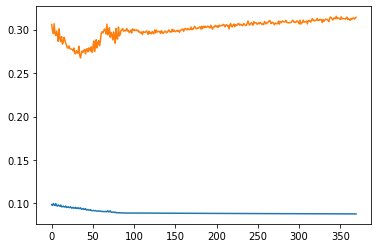

In [402]:
plt.plot(TTTTT_loss, label = 'Train Loss')
plt.plot(VVVVV_loss, label = 'Valid Loss')

In [392]:
print(current_nodes[best_node])

[ 14   1 227]


In [393]:
print(len(Train_MV_1))

244


In [375]:
test_predictions = model.predict(Test_MV_block)

In [376]:
mgc_head = test_predictions[:, 0:mgc_dim]
mgc_ref = Test_WAV_block[:, 0:mgc_dim]
from nnmnkwii.metrics import melcd

MCD = melcd(mgc_head[:,1:mgc_dim], mgc_ref[:,1:mgc_dim], lengths=None)
print(MCD)

14.861459603456279
